---
# Predictive Marketing :<br>Travel Rewards Mastercard®

## - ATB Datathon Team 3
-----

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('seaborn-colorblind')
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib notebook

## Load datasets

In [2]:
age_dim = pd.read_csv('Data/AGE_DIM.csv')
category_dim = pd.read_csv('Data/CATEGORY_DIM.csv',encoding='latin-1')
#chq_trxn = pd.read_csv('Data/CHQ_ACCT_TRXN_FACT.csv')
crd_trxn = pd.read_csv('Data/CRD_ACCT_TRXN_FACT.csv')
customers = pd.read_csv('Data/CUSTOMERS_FACT.csv')
holdings = pd.read_csv('Data/HOLDINGS_FACT.csv')
segment_dim = pd.read_csv('Data/SEGMENT_DIM.csv')
ref = pd.read_excel('Data/REF_DATA_DICT.xlsx')

In [3]:
ref.head()

,Table,Field,What it is,# of records
0,CUSTOMERS_FACT,CUST_OID,Customer identifier,12911.0
1,NaN,AGE_FK,"Age bucket: 18-24, 25-29, ..., 45-49, Dimensio...",NaN
2,NaN,SEGMENT_FK,Population segment: 1 - 57; Dimension table: S...,12911.0
3,HOLDINGS_FACT,CUST_OID,see CUSTOMERS_FACT,NaN
4,NaN,HOLDING_OID,Product identifier; products can be either che...,NaN


In [4]:
customers.head()

,CUST_OID,AGE_FK,SEGMENT_FK
0,1,4,8
1,2,1,32
2,5,1,34
3,6,3,55
4,7,5,20


In [5]:
holdings.head() #Many-to-Many 

,CUST_OID,HOLDING_OID
0,1,12990
1,2,13358
2,2,14055
3,5,12153
4,6,11702


In [6]:
crd_trxn.head() 

,DATE,TIME,HOLDING_OID,AMT,CATEGORY_FK
0,02JAN1960,0:00:36,7095,70.70,4121
1,02JAN1960,0:00:51,11424,506.02,5200
2,02JAN1960,0:03:42,14038,19.00,5735
3,02JAN1960,0:03:55,284,87.50,7011
4,02JAN1960,0:04:23,8057,0.20,4121


## Pre-processing & Merging

<img src="Images/relations.png" width="1000" />

In [7]:
#normalize AMT : + for spending
#chq_trxn['AMT'] = chq_trxn['AMT'] *chq_trxn['DB_CR'] * (-1)
#chq_trxn.drop('DB_CR',axis=1,inplace=True)

#Combine Date and Time and convert to datetime
#chq_trxn['DATETIME'] = pd.to_datetime((chq_trxn['DATE']+chq_trxn['TIME']), 
                                      #errors='raise',format="%d%b%Y%H:%M:%S")
#chq_trxn.drop(['DATE','TIME'],axis=1,inplace=True)

crd_trxn['DATETIME'] = pd.to_datetime((crd_trxn['DATE']+crd_trxn['TIME']), 
                                      errors='raise',format="%d%b%Y%H:%M:%S")
crd_trxn.drop(['DATE','TIME'],axis=1,inplace=True)


In [8]:
#Clean customer & holdings so that 1 holding -> 1 customer
cust_df = ( pd.merge(pd.merge(pd.merge(holdings,
                  customers,
                    'left'),
                     age_dim,
                     'left',left_on = 'AGE_FK', right_on = 'AGE'),
                        segment_dim, 
                        'left', left_on = 'SEGMENT_FK', right_on='SEGMENT')
           .drop(['AGE_FK', 'SEGMENT_FK', 'AGE', 
                  'SEGMENT','SEGMENT_GROUP_DESC'],axis=1)
           .sort_values(['CUST_OID','HOLDING_OID',
                         'AGE_DESC','SEGMENT_GROUP'])
          )

cust_df['HOLDING_OWNERS'] = (cust_df.groupby('HOLDING_OID')['CUST_OID']
                             .transform(lambda x: x.count()))

cust_df['CUST_OID'] = cust_df['CUST_OID'].astype(str)   
#cust_df['HOLDING_OID'] = cust_df['HOLDING_OID'].astype(str)

cust_df['HOLDING_OWNERS'] = (cust_df.groupby('HOLDING_OID')['CUST_OID']
                             .transform(lambda x: x.count()))
cust_df['CUST_HOLDINGS'] = (cust_df.groupby('CUST_OID')['HOLDING_OID']
                            .transform(lambda x: x.count()))

def combine_holders(grp):
    #this function combine multiple owners with majority vote

    cust_oid = '_'.join(grp['CUST_OID'].values).strip()
    age = grp['AGE_DESC'].value_counts().idxmax()
    segment = grp['SEGMENT_GROUP'].value_counts().idxmax()
    grp['CUST_OID'] = cust_oid
    grp['AGE_DESC'] = age
    grp['SEGMENT_GROUP'] = segment
    grp['CUST_HOLDINGS'] = grp['CUST_HOLDINGS'].max()
    
    return grp

#Encode shared holders as "ONE", and drop duplicateds
cust_cleaned = (cust_df.groupby('HOLDING_OID').apply(
    lambda x : combine_holders(x) if 
    (x['HOLDING_OWNERS']>1).any() else x)
            .drop_duplicates())

In [9]:
#Join trasactions with customer ID ONLY
#chq_trxn = pd.merge(chq_trxn, cust_cleaned[['HOLDING_OID','CUST_OID']],
                   #how='left')

crd_trxn = pd.merge(crd_trxn, cust_cleaned[['HOLDING_OID','CUST_OID']],
                   how='left')

In [10]:
#Customers of interest are those who has transactions in Jan and Feb
crd_trxn.set_index('DATETIME', inplace=True)

crd_12_id = ( set(crd_trxn.loc['1960-01']['CUST_OID'].unique()) & 
  set(crd_trxn.loc['1960-02']['CUST_OID'].unique()) )
len(crd_12_id) 
#3970 have credit trxn in both Jan and Feb

3970

In [11]:
#Cut-off times: Feb 29
crd_12 = crd_trxn.loc['1960-01':'1960-02'].groupby('CUST_OID').filter(
lambda x: x['CUST_OID'].iloc[0] in crd_12_id)
crd_12.reset_index(inplace=True)
crd_12 = pd.merge(crd_12,category_dim.set_index("CATEGORY"),
         'left', left_on = 'CATEGORY_FK',right_index=True)
crd_trxn.reset_index( inplace=True)

In [12]:
def plot_wordcloud(df, groupby, tokenize=True):

    #plot the category frequency word cloud
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk import FreqDist
    from wordcloud import WordCloud

    stopwords_set = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r'\w+')
    if tokenize : 
        tokens = tokenizer.tokenize(' '.join(df[groupby].fillna('Unknown').values))
        tokens = [w for w in tokens 
                       if not w.lower() in stopwords_set]
    if not tokenize:
        tokens = df[groupby].values
        
    freq_dist  = FreqDist(tokens)
    #categories to remove 
    remove_list = ['Services','Service',
                  'Payment','Stores']
    for item in remove_list:
        freq_dist[item]=0
    mycloud = WordCloud(background_color='white',
                       width=640,height=360,
                       normalize_plurals=True).generate_from_frequencies(freq_dist)
    plt.figure(figsize = (8,4.5) ,dpi=90)
    plt.imshow(mycloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig("Images/wordcloud.png")
    #plt.title('Transaction Distribution\n',fontsize=30)


### Transaction Keywords Frequency: 

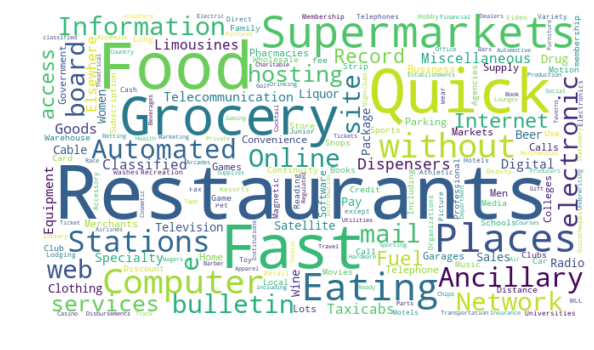

In [13]:
plot_wordcloud(crd_12,'CATEGORY_DESC', tokenize=True)

In [14]:
#Data to use for feature engineering
crd_12.head()

,DATETIME,HOLDING_OID,AMT,CATEGORY_FK,CUST_OID,CATEGORY_DESC
0,1960-01-02 00:00:36,7095,70.70,4121,4638,Taxicabs and Limousines
1,1960-01-02 00:00:51,11424,506.02,5200,15004,Home Supply Warehouse
2,1960-01-02 00:03:42,14038,19.00,5735,9353,Record Stores
3,1960-01-02 00:03:55,284,87.50,7011,14839,"Lodging - Hotels, Motels, and Resorts"
4,1960-01-02 00:04:23,8057,0.20,4121,19969,Taxicabs and Limousines


In [15]:
crd_12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137794 entries, 0 to 137793
Data columns (total 6 columns):
DATETIME         137794 non-null datetime64[ns]
HOLDING_OID      137794 non-null int64
AMT              137794 non-null float64
CATEGORY_FK      137794 non-null int64
CUST_OID         137794 non-null object
CATEGORY_DESC    137794 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.3+ MB


## Feature Engineering

In [16]:
#Re-grouping the categories
mcc_dist = (crd_12.groupby(['CATEGORY_FK', 'CATEGORY_DESC'])['CATEGORY_DESC']
            .count().sort_values(ascending=False))

mcc_dist = pd.DataFrame({'Frequency': mcc_dist,
             'Percentage':mcc_dist/mcc_dist.sum()*100} ).reset_index(level=1)
mcc_dist.head()

,CATEGORY_DESC,Frequency,Percentage
CATEGORY_FK,,,
5814,Quick Payment Service-Fast Food Restaurants,17528,12.72
5411,Grocery Stores and Supermarkets,13019,9.45
5812,Eating Places and Restaurants,10162,7.37
5541,Service Stations (with or without Ancillary Se...,5987,4.34
4816,Computer Network/Information Services and othe...,5487,3.98


In [17]:
mcc_dist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 5814 to 0
Data columns (total 3 columns):
CATEGORY_DESC    365 non-null object
Frequency        365 non-null int64
Percentage       365 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.4+ KB


In [18]:
print('{:.0%} categories represent only {:.0f}% transactions.'.format(
    mcc_dist[mcc_dist['Percentage']< 0.2]['Percentage'].count()/365,
    mcc_dist[mcc_dist['Percentage']< 0.2]['Percentage'].sum()))

81% categories represent only 8% transactions.


<img src="Images/mcg_shot.png" width="800" />

In [19]:
#load mcg mapping
mcg = pd.read_csv('Data/mcc_grouping.csv')

In [20]:
#Map the categories to MCC Groups
group_df = pd.merge(mcc_dist, mcg.set_index('CATEGORY').drop('CATEGORY_DESC',axis=1),
        'left',left_index=True,right_index=True)
#code anything with >0.1% frequency as their MCC, otherwise MCG.
group_df['mygroup'] = np.where(group_df['Percentage']>0.2,
                             group_df.index,group_df['MCG'] )
group_df['mygroup_desc'] = np.where(group_df['Percentage']>0.2,
                             group_df['CATEGORY_DESC'],group_df['MCG_DESC'] )
group_df.head()

,CATEGORY_DESC,Frequency,Percentage,MCG,MCG_DESC,mygroup,mygroup_desc
CATEGORY_FK,,,,,,,
5814,Quick Payment Service-Fast Food Restaurants,17528,12.72,22.0,Restaurants,5814.0,Quick Payment Service-Fast Food Restaurants
5411,Grocery Stores and Supermarkets,13019,9.45,23.0,Retail Stores,5411.0,Grocery Stores and Supermarkets
5812,Eating Places and Restaurants,10162,7.37,22.0,Restaurants,5812.0,Eating Places and Restaurants
5541,Service Stations (with or without Ancillary Se...,5987,4.34,11.0,Gas Stations,5541.0,Service Stations (with or without Ancillary Se...
4816,Computer Network/Information Services and othe...,5487,3.98,25.0,Telecom and Data Utilities,4816.0,Computer Network/Information Services and othe...


In [21]:
#Join transaction and groupings 
crd_df = pd.merge(crd_12, group_df[['MCG','MCG_DESC','mygroup','mygroup_desc']], 'left',
                                 left_on='CATEGORY_FK',
                                 right_index=True)
crd_trxn_df = pd.merge(crd_trxn, group_df[['MCG','MCG_DESC','mygroup','mygroup_desc']], 'left',
                                 left_on='CATEGORY_FK',
                                 right_index=True)

In [22]:
pd.isnull(crd_df['mygroup_desc']).sum()

13

In [23]:
#Sort by date in ascending order
crd_df.sort_values('DATETIME',inplace = True)
crd_df.head()

#Create time-series indicators
crd_df['dayofmonth'] = crd_df['DATETIME'].dt.day.astype(str) + 'th Day'
crd_df['dayofweek'] = crd_df['DATETIME'].dt.day_name().astype(str)
crd_df['hourofday'] = crd_df['DATETIME'].dt.hour.astype(str) + ':00'
crd_df['isweekend'] = np.where((crd_df['dayofweek']=='Saturday') | 
                               (crd_df['dayofweek']=='Sunday'),
                               'Weekend','Non-Weekend')


In [24]:
crd_df.head()

,DATETIME,HOLDING_OID,AMT,CATEGORY_FK,CUST_OID,CATEGORY_DESC,MCG,MCG_DESC,mygroup,mygroup_desc,dayofmonth,dayofweek,hourofday,isweekend
0,1960-01-02 00:00:36,7095,70.70,4121,4638,Taxicabs and Limousines,26.0,Transportation,4121.0,Taxicabs and Limousines,2th Day,Saturday,0:00,Weekend
1,1960-01-02 00:00:51,11424,506.02,5200,15004,Home Supply Warehouse,23.0,Retail Stores,5200.0,Home Supply Warehouse,2th Day,Saturday,0:00,Weekend
2,1960-01-02 00:03:42,14038,19.00,5735,9353,Record Stores,15.0,Miscellaneous Stores,5735.0,Record Stores,2th Day,Saturday,0:00,Weekend
3,1960-01-02 00:03:55,284,87.50,7011,14839,"Lodging - Hotels, Motels, and Resorts",13.0,Hotels and Motels,7011.0,"Lodging - Hotels, Motels, and Resorts",2th Day,Saturday,0:00,Weekend
4,1960-01-02 00:04:23,8057,0.20,4121,19969,Taxicabs and Limousines,26.0,Transportation,4121.0,Taxicabs and Limousines,2th Day,Saturday,0:00,Weekend


In [25]:
#Define aggregators 
def my_agg(grp, recency=False):
    #every mcg is a category in two month
    
    data = {
            'AMT_SUM':grp['AMT'].sum(),
            'AMT_MEAN':grp['AMT'].mean(),
             'AMT_STD':grp['AMT'].mean(),
            'AMT_MIN': grp['AMT'].min(),
            'AMT_MAX': grp['AMT'].max(),
             'FREQ':grp['AMT'].count(),
            'GAP_MEAN':(grp['DATETIME'].diff().mean().total_seconds()/86400 
                        if grp['DATETIME'].count() > 1 else 0),
            'GAP_STD':(grp['DATETIME'].diff().std().total_seconds()/86400 
                       if grp['DATETIME'].count() > 2 else 0)}
    
    if recency == True:
        data['AMT_RECENT'] = grp['AMT'].iloc[-1]
        data['DISTANCE_RECENT'] = 60 - grp['DATETIME'].iloc[-1].dayofyear
        
    return pd.Series(data=data)

def my_transform(no_index_df, group_list,recency=False):
    
    values = ['AMT_SUM', 'AMT_MEAN', 'AMT_STD', 'AMT_MIN', 'AMT_MAX',
              'FREQ', 'GAP_MEAN', 'GAP_STD']
    if recency:
        values = values + ['AMT_RECENT', 'DISTANCE_RECENT']
    #transfomr and return merged
    #group 
    df_t = no_index_df.groupby(group_list).apply(
    lambda x: my_agg(x, recency=recency))
    
    #pivot
    if len(group_list) >1:
        df_t = pd.pivot_table(df_t.reset_index(),
                       index='CUST_OID', 
                   columns=group_list[1:],
                   values = values, fill_value=0)
    #flatten 
    if len(group_list) ==3 :
        df_t.columns = ['_'.join([agg, cycle ,str(group)]).strip() 
                        for agg, cycle, group in df_t.columns]

    if len(group_list) ==2  :
        df_t.columns = ['_'.join([agg, str(cat_or_time)]).strip() 
                        for agg, cat_or_time in df_t.columns]
           
    return df_t.reset_index()

### 1 Level - Customer 

In [26]:
#Aggregate by 1. Customer,
#and the most recent acticity
crd_cust = my_transform(crd_df, ['CUST_OID'], recency=True)
crd_cust.head()

,CUST_OID,AMT_SUM,AMT_MEAN,AMT_STD,AMT_MIN,AMT_MAX,FREQ,GAP_MEAN,GAP_STD,AMT_RECENT,DISTANCE_RECENT
0,10000,131.51,21.92,21.92,11.15,29.07,6.0,10.03,10.51,17.95,3.0
1,10003,528.40,35.23,35.23,0.00,319.90,15.0,3.74,4.44,7.26,0.0
2,10004,513.16,36.65,36.65,1.14,157.67,14.0,3.53,4.86,27.21,8.0
3,10018,516.42,46.95,46.95,3.65,158.95,11.0,3.48,5.00,39.00,3.0
4,10024,979.08,27.97,27.97,1.72,201.90,35.0,1.62,1.52,1.72,2.0


### 2 Levels - Customer, + Time OR Group

In [27]:
#Aggregate by 1. Customer, 2. Groups
#and the most recent acticity
crd_group = my_transform(crd_df, ['CUST_OID','mygroup_desc'], recency=True)
crd_group.head()

,CUST_OID,AMT_MAX_Advertising Services,AMT_MAX_Airlines,AMT_MAX_Amusement and Entertainment,AMT_MAX_Associations,AMT_MAX_Auto Rental,AMT_MAX_Automated Fuel Dispensers,AMT_MAX_Automobiles and Vehicles,AMT_MAX_Automotive Parts and Accessories Stores,AMT_MAX_Bakeries,...,GAP_STD_Travel Agencies,GAP_STD_Utilities,"GAP_STD_Utilities-Electric, Gas, Water, and Sanitary",GAP_STD_Variety Stores,GAP_STD_Video Game Arcades and Establishments,GAP_STD_Westjet Airlines-WESTJET,GAP_STD_Wholesale Club with or without membership fee,GAP_STD_Wholesale Trade,GAP_STD_Women's Accessory and Specialty Stores,GAP_STD_Women's Ready-to-Wear Stores
0,10000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
1,10003,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,10004,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,10018,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,10024,0.0,0.0,0.0,0.0,0.0,42.87,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.65,0.0,0.0,0.0


In [28]:
#Aggregate by 1. Customer, 2. Weekend v.s.Non-Weekend
crd_weekend = my_transform(crd_df, ['CUST_OID','isweekend'], recency=False)
crd_weekend.head()

,CUST_OID,AMT_MAX_Non-Weekend,AMT_MAX_Weekend,AMT_MEAN_Non-Weekend,AMT_MEAN_Weekend,AMT_MIN_Non-Weekend,AMT_MIN_Weekend,AMT_STD_Non-Weekend,AMT_STD_Weekend,AMT_SUM_Non-Weekend,AMT_SUM_Weekend,FREQ_Non-Weekend,FREQ_Weekend,GAP_MEAN_Non-Weekend,GAP_MEAN_Weekend,GAP_STD_Non-Weekend,GAP_STD_Weekend
0,10000,29.07,0.00,21.92,0.00,11.15,0.00,21.92,0.00,131.51,0.00,6,0,10.03,0.00,10.51,0.00
1,10003,319.90,9.24,42.91,4.48,0.00,1.09,42.91,4.48,514.97,13.43,12,3,4.76,6.75,5.20,9.55
2,10004,147.75,157.67,35.86,37.45,1.20,1.14,35.86,37.45,251.04,262.12,7,7,5.62,6.02,6.57,11.53
3,10018,158.95,0.00,46.95,0.00,3.65,0.00,46.95,0.00,516.42,0.00,11,0,3.48,0.00,5.00,0.00
4,10024,201.90,42.87,32.52,14.83,4.60,1.72,32.52,14.83,845.57,133.51,26,9,2.08,6.89,2.11,7.31


In [29]:
#Aggregate by 1. Customer, 2. Day of Week
crd_dayofweek = my_transform(crd_df, ['CUST_OID','dayofweek'], recency=False)
crd_dayofweek.head()

,CUST_OID,AMT_MAX_Friday,AMT_MAX_Monday,AMT_MAX_Saturday,AMT_MAX_Sunday,AMT_MAX_Thursday,AMT_MAX_Tuesday,AMT_MAX_Wednesday,AMT_MEAN_Friday,AMT_MEAN_Monday,...,GAP_MEAN_Thursday,GAP_MEAN_Tuesday,GAP_MEAN_Wednesday,GAP_STD_Friday,GAP_STD_Monday,GAP_STD_Saturday,GAP_STD_Sunday,GAP_STD_Thursday,GAP_STD_Tuesday,GAP_STD_Wednesday
0,10000,17.95,0.00,0.00,0.00,27.16,11.15,29.07,17.95,0.00,...,20.98,0.00e+00,0.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,10003,77.58,7.26,9.24,0.00,319.90,0.00,86.10,21.42,7.26,...,10.64,0.00e+00,4.63,24.13,0.00,9.55,0.00,5.15,0.00,8.00
2,10004,13.80,17.64,157.67,27.21,1.20,147.75,41.15,13.80,17.31,...,0.00,2.16e+01,0.00,0.00,0.00,0.00,2.97,0.00,0.00,0.00
3,10018,138.17,43.45,0.00,0.00,158.95,15.64,0.00,88.58,38.40,...,3.61,9.11e-03,0.00,0.00,0.00,0.00,0.00,7.18,0.00,0.00
4,10024,63.60,85.40,42.87,25.50,201.90,66.00,27.30,21.27,32.81,...,4.79,8.16e+00,10.48,8.31,4.46,10.46,6.88,4.04,10.17,5.17


### 3 Levels - Customer, + Time AND Group

In [30]:
#Aggregate first by 1. Customer, 2. (Non-)Weekend 3. Groups
crd_weekend_group  = my_transform(crd_df, ['CUST_OID', 'isweekend','mygroup_desc'])
crd_weekend_group.head()

,CUST_OID,AMT_MAX_Non-Weekend_Advertising Services,AMT_MAX_Non-Weekend_Airlines,AMT_MAX_Non-Weekend_Amusement and Entertainment,AMT_MAX_Non-Weekend_Associations,AMT_MAX_Non-Weekend_Auto Rental,AMT_MAX_Non-Weekend_Automated Fuel Dispensers,AMT_MAX_Non-Weekend_Automobiles and Vehicles,AMT_MAX_Non-Weekend_Automotive Parts and Accessories Stores,AMT_MAX_Non-Weekend_Bakeries,...,GAP_STD_Weekend_Travel Agencies,GAP_STD_Weekend_Utilities,"GAP_STD_Weekend_Utilities-Electric, Gas, Water, and Sanitary",GAP_STD_Weekend_Variety Stores,GAP_STD_Weekend_Video Game Arcades and Establishments,GAP_STD_Weekend_Westjet Airlines-WESTJET,GAP_STD_Weekend_Wholesale Club with or without membership fee,GAP_STD_Weekend_Wholesale Trade,GAP_STD_Weekend_Women's Accessory and Specialty Stores,GAP_STD_Weekend_Women's Ready-to-Wear Stores
0,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10024,0.0,0.0,0.0,0.0,0.0,24.1,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
#Aggregate by 1. Customer, 2. Day of Week 3. Groups
crd_dayofweek_group  = my_transform(crd_df, ['CUST_OID', 'dayofweek','mygroup_desc'])
crd_dayofweek_group.head()

,CUST_OID,AMT_MAX_Friday_Advertising Services,AMT_MAX_Friday_Airlines,AMT_MAX_Friday_Amusement and Entertainment,AMT_MAX_Friday_Associations,AMT_MAX_Friday_Auto Rental,AMT_MAX_Friday_Automated Fuel Dispensers,AMT_MAX_Friday_Automobiles and Vehicles,AMT_MAX_Friday_Automotive Parts and Accessories Stores,AMT_MAX_Friday_Bakeries,...,GAP_STD_Wednesday_Travel Agencies,GAP_STD_Wednesday_Utilities,"GAP_STD_Wednesday_Utilities-Electric, Gas, Water, and Sanitary",GAP_STD_Wednesday_Variety Stores,GAP_STD_Wednesday_Video Game Arcades and Establishments,GAP_STD_Wednesday_Westjet Airlines-WESTJET,GAP_STD_Wednesday_Wholesale Club with or without membership fee,GAP_STD_Wednesday_Wholesale Trade,GAP_STD_Wednesday_Women's Accessory and Specialty Stores,GAP_STD_Wednesday_Women's Ready-to-Wear Stores
0,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,10004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,10018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,10024,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


### Put Together

In [32]:
feature_dfs = [crd_cust, 
               crd_group,crd_weekend,crd_dayofweek,
               crd_weekend_group,crd_dayofweek_group]
crd_union = pd.concat([df.set_index('CUST_OID') for df in feature_dfs ],axis=1, join='outer')
crd_union.head()

,AMT_SUM,AMT_MEAN,AMT_STD,AMT_MIN,AMT_MAX,FREQ,GAP_MEAN,GAP_STD,AMT_RECENT,DISTANCE_RECENT,...,GAP_STD_Wednesday_Travel Agencies,GAP_STD_Wednesday_Utilities,"GAP_STD_Wednesday_Utilities-Electric, Gas, Water, and Sanitary",GAP_STD_Wednesday_Variety Stores,GAP_STD_Wednesday_Video Game Arcades and Establishments,GAP_STD_Wednesday_Westjet Airlines-WESTJET,GAP_STD_Wednesday_Wholesale Club with or without membership fee,GAP_STD_Wednesday_Wholesale Trade,GAP_STD_Wednesday_Women's Accessory and Specialty Stores,GAP_STD_Wednesday_Women's Ready-to-Wear Stores
CUST_OID,,,,,,,,,,,,,,,,,,,,,
10000,131.51,21.92,21.92,11.15,29.07,6.0,10.03,10.51,17.95,3.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
10003,528.40,35.23,35.23,0.00,319.90,15.0,3.74,4.44,7.26,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
10004,513.16,36.65,36.65,1.14,157.67,14.0,3.53,4.86,27.21,8.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
10018,516.42,46.95,46.95,3.65,158.95,11.0,3.48,5.00,39.00,3.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
10024,979.08,27.97,27.97,1.72,201.90,35.0,1.62,1.52,1.72,2.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [33]:
crd_union.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3970 entries, 10000 to 9994
Columns: 7734 entries, AMT_SUM to GAP_STD_Wednesday_Women's Ready-to-Wear Stores
dtypes: float64(6574), int64(1160)
memory usage: 234.3+ MB


### Add  Demographic Features

In [34]:
#create dummy features for customer's demographic attributes
cust_dummy = pd.get_dummies(cust_cleaned.drop([
    'HOLDING_OID','HOLDING_OWNERS'],axis=1).drop_duplicates(),
                           columns =['AGE_DESC','SEGMENT_GROUP'] )
cust_dummy.head()

,CUST_OID,CUST_HOLDINGS,AGE_DESC_18_24,AGE_DESC_25_29,AGE_DESC_30_34,AGE_DESC_35_39,AGE_DESC_40_44,AGE_DESC_45_49,SEGMENT_GROUP_NC,SEGMENT_GROUP_P1,...,SEGMENT_GROUP_P3,SEGMENT_GROUP_P4,SEGMENT_GROUP_P5,SEGMENT_GROUP_S1,SEGMENT_GROUP_S2,SEGMENT_GROUP_S3,SEGMENT_GROUP_S4,SEGMENT_GROUP_S5,SEGMENT_GROUP_T1,SEGMENT_GROUP_T2
0,1_8609,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2,2,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,6,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,7,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [35]:
crd_final = pd.merge(crd_union, 
         cust_dummy.set_index('CUST_OID'),
         'left',left_index = True,right_index= True )
          
crd_final.head()        

,AMT_SUM,AMT_MEAN,AMT_STD,AMT_MIN,AMT_MAX,FREQ,GAP_MEAN,GAP_STD,AMT_RECENT,DISTANCE_RECENT,...,SEGMENT_GROUP_P3,SEGMENT_GROUP_P4,SEGMENT_GROUP_P5,SEGMENT_GROUP_S1,SEGMENT_GROUP_S2,SEGMENT_GROUP_S3,SEGMENT_GROUP_S4,SEGMENT_GROUP_S5,SEGMENT_GROUP_T1,SEGMENT_GROUP_T2
CUST_OID,,,,,,,,,,,,,,,,,,,,,
10000,131.51,21.92,21.92,11.15,29.07,6.0,10.03,10.51,17.95,3.0,...,0,0,0,0,0,0,0,0,0,0
10003,528.40,35.23,35.23,0.00,319.90,15.0,3.74,4.44,7.26,0.0,...,0,0,0,0,0,0,1,0,0,0
10004,513.16,36.65,36.65,1.14,157.67,14.0,3.53,4.86,27.21,8.0,...,0,0,0,0,0,0,0,0,1,0
10018,516.42,46.95,46.95,3.65,158.95,11.0,3.48,5.00,39.00,3.0,...,0,0,0,0,0,0,0,0,1,0
10024,979.08,27.97,27.97,1.72,201.90,35.0,1.62,1.52,1.72,2.0,...,0,0,1,0,0,0,0,0,0,0


In [36]:
crd_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3970 entries, 10000 to 9994
Columns: 7754 entries, AMT_SUM to SEGMENT_GROUP_T2
dtypes: float64(6574), int64(1161), uint8(19)
memory usage: 234.5+ MB


## Prediciton Engineering

In [37]:
# Find the customers who travels in March
tvl_df = crd_trxn_df.set_index('DATETIME').loc['1960-03'].groupby('CUST_OID').filter(
    lambda x: (x['MCG']==1 ).any() | (x['MCG']==13 ).any() )

tvl_id = set(tvl_df['CUST_OID'].unique())

wj_id = (set(crd_trxn[crd_trxn['CATEGORY_FK']==3180]
             .set_index('DATETIME').loc['1960-03','CUST_OID'].unique()))

def generate_label(df, positive_id):
    if df.index.name == 'CUST_OID' :
        label = pd.Series([1 if id in positive_id else 0 
         for id in df.index])
    if 'CUST_OID' in df.columns:
        label = pd.Series([1 if id in positive_id else 0 
         for id in df['CUST_OID']])
    return label

In [38]:
tvl_dist = generate_label(crd_12.drop_duplicates(['CUST_OID']),tvl_id).value_counts()

wj_dist = generate_label(crd_12.drop_duplicates(['CUST_OID']),wj_id).value_counts()

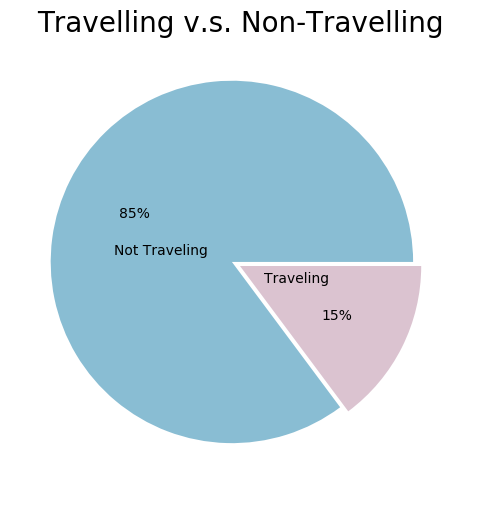

In [39]:
plt.figure(figsize=(6,6),dpi=100)
plt.pie(tvl_dist,labels=['Not Traveling','Traveling'],
        autopct='%1.0f%%' ,labeldistance=0.15, 
        explode=[0.05,0],colors= ['#89bdd3','#dbc3d0'])
plt.title('Travelling v.s. Non-Travelling', fontsize=20)
plt.savefig('Images/travel_dist.png');

## Modeling Building 

In [40]:
#create label
label_final = generate_label(crd_final, tvl_id)
print('{:.2%} customers will travel in the next month'.format(label_final.sum()/label_final.count()))

14.81% customers will travel in the next month


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(crd_final,
                                                   label_final,
                                                   random_state=0)


### Make Pipelines for GridSearch

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [43]:
#universal MinMaxScaler
scaler = MinMaxScaler()
#Logistic Regression
lr= LogisticRegression(solver='liblinear',max_iter=1000, random_state=0)
pipe_lr = Pipeline(steps=[('scaler',scaler),('lr',lr)])
param_grid_lr ={'lr__C':[0.01,0.1,1,10,100],
           'lr__class_weight':[{1:5},{1:6},{1:7}]}

cv_lr = GridSearchCV(pipe_lr,param_grid_lr, cv=3,
                    scoring = 'roc_auc')
#Decision Tree
df= DecisionTreeClassifier(random_state=0)
pipe_df = Pipeline(steps=[('scaler',scaler),('df',df)])
param_grid_df ={'df__max_depth':[2,3,4,5],
           'df__class_weight':[{1:2},{1:3}]}
cv_dt = GridSearchCV(pipe_df,param_grid_df, cv=3,
                    scoring = 'roc_auc')
#Random Forest
rf= RandomForestClassifier(n_estimators=100, random_state=0)
pipe_rf = Pipeline(steps=[('scaler',scaler),('rf',rf)])
param_grid_rf ={'rf__max_depth':[2, 3, 4],
           'rf__class_weight':[{1:5},{1:6},{1:7}]}
cv_rf = GridSearchCV(pipe_rf,param_grid_rf, cv=3,
                    scoring = 'roc_auc')
cv_lr.fit(X_train, y_train)
cv_dt.fit(X_train, y_train)
cv_rf.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype u

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype u

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype u

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_i...ators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'rf__max_depth': [2, 3, 4], 'rf__class_weight': [{1: 5}, {1: 6}, {1: 7}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

## Model Evaluation

In [44]:
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Confusion Matrices (Normalized)

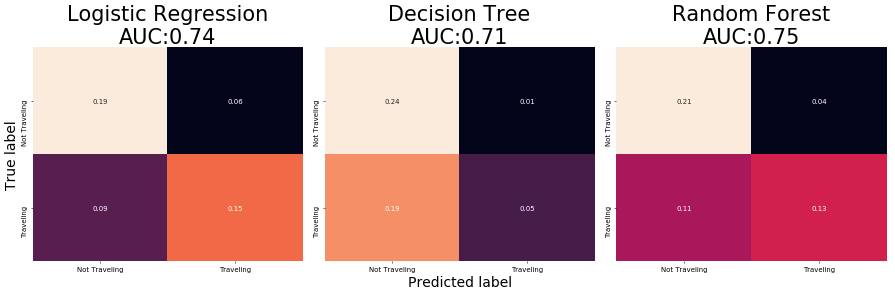

In [45]:
names = ["Logistic Regression",'Decision Tree','Random Forest']
estimators  = [cv_lr.best_estimator_.fit(X_train_scaled,y_train),
               cv_dt.best_estimator_.fit(X_train_scaled,y_train) ,
               cv_rf.best_estimator_.fit(X_train_scaled,y_train)] 

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6),dpi=50)

norm = np.array([[1.0 / (label_final==0).sum(),1.0/(label_final==0).sum()],
                 [1.0/(label_final==1).sum(),1.0/(label_final==1).sum()]])

for estimator, name, ax in zip(estimators, names, [ax1,ax2,ax3]):
    ax.clear()
    
    confusion = confusion_matrix(y_test, 
                                 estimator.predict(X_test_scaled))
    confusion_normed  = confusion *norm
    
    df_cm = pd.DataFrame(confusion_normed,
                        index=['Not Traveling','Traveling'],
                        columns=['Not Traveling','Traveling'])

    auc_score = roc_auc_score(y_test, 
                              estimator.predict_proba(X_test_scaled)[:,1])
    sns.heatmap(df_cm, annot=True, ax = ax, cbar=None, fmt=".2f")
    ax.set_title('{}\nAUC:{:.2f}'.format(name,auc_score), fontsize=30)
    
    ax1.set_ylabel('True label', fontsize=20)
    ax2.set_xlabel('Predicted label', fontsize=20)

plt.tight_layout()
plt.savefig('Images/confusion_matrices.png');

### Interpretation from Decision Tree

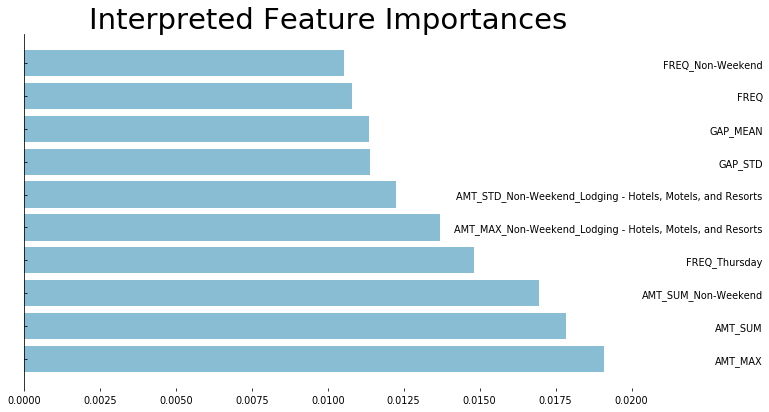

In [50]:
#Top 10 Important Featues
important_features = pd.Series(data=cv_rf.best_estimator_.steps[1][1].feature_importances_, 
                               index=crd_final.columns).sort_values(ascending=False)[:10]

plt.figure(figsize = (12, 6), dpi =70)
plt.barh(important_features.index,
         important_features.values,color='#89bdd3')
#plt.xlabel("Feature importance")
plt.title("Interpreted Feature Importances", fontsize=30)
plt.subplots_adjust(left=0.25)
#plt.set_ylabel('')
plt.tick_params(axis="y",direction="in", pad=-760)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#plt.tick_params(axis="x",direction="in", pad=-100)
plt.tight_layout()
plt.savefig('Images/feature_importances.png')

In [47]:
#visualize decision trees and feature importance
from adspy_shared_utilities import plot_decision_tree

graph = plot_decision_tree(clf=cv_dt.best_estimator_.steps[1][1], 
                           feature_names=crd_final.columns, 
                           class_names=['Travelling', 'Not Travelling'])
graph.render('decision_visual',view=False)

'decision_visual.pdf'

### Decision Tree Visulization, First 2 Levels

<img src="Images/decision_visual.png" width="1000" />

## Next Steps...

### Take a look at airlines' customer distribution:


<img src="Images/airline_heat_map.png" width="600" /> 

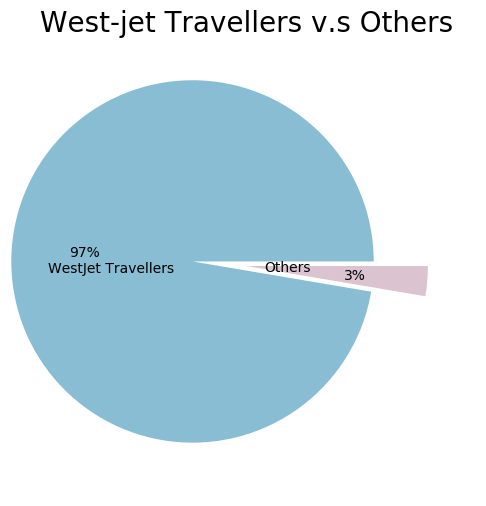

In [53]:
plt.figure(figsize=(6,6),dpi=100)
plt.pie(wj_dist,labels=['\nWestJet Travellers','Others'],
        autopct='%1.0f%%' ,labeldistance=0.1, 
        explode=[0.3,0],colors= ['#89bdd3','#dbc3d0'])
plt.title('West-jet Travellers v.s Others', fontsize=20);
plt.savefig('Images/imbalanced.png')